In [1]:
import sim          # librería para conectar con CoppeliaSim
import sympy as sp  # librería para cálculo simbólico
import numpy as np
from sympy import *
import cv2                      # opencv
import matplotlib.pyplot as plt # pyplot
from sympy import *
from sympy.physics.vector import init_vprinting
import time
import argparse
from sympy.physics.mechanics import dynamicsymbols
import pytesseract
from PIL import Image
import os
import re
import math
from pythonRLSA import rlsa
from itertools import tee
from datetime import datetime
import time
from tkinter import *
from tkinter.ttk import *
from fuzzywuzzy import process
import re
import datetime
import platform

C:\Users\cuent\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


#### Requisitos OCR:

!pip install pipenv
!mkdir ocr_server && cd ocr_server && pipenv install --three
!pip install Pillow
!pip install pythonRLSA
!pip install fuzzywuzzy

#### Funciones coppelia

In [2]:
def connect(port):
# Establece la conexión a VREP
# port debe coincidir con el puerto de conexión en VREP
# retorna el número de cliente o -1 si no puede establecer conexión
    sim.simxFinish(-1) # just in case, close all opened connections
    clientID=sim.simxStart('127.0.0.1',port,True,True,2000,5) # Conectarse
    if clientID == 0: print("conectado a", port)
    else: print("no se pudo conectar")
    return clientID

def setEffector(val):
# función que acciona el efector final remotamente
# val es Int con valor 0 ó 1 para desactivar o activar el actuador final.
    res,retInts,retFloats,retStrings,retBuffer=sim.simxCallScriptFunction(clientID,
        "suctionPad", sim.sim_scripttype_childscript,"setEffector",[val],[],[],"", sim.simx_opmode_blocking)
    return res

def getDistance(val):
# función que acciona el efector final remotamente
# val es Int con valor 0 ó 1 para desactivar o activar el actuador final.
    res,retInts,retFloats,retStrings,retBuffer=sim.simxCallScriptFunction(clientID,
        "Proximity_sensor", sim.sim_scripttype_childscript,"getDistance",[val],[],[],"", sim.simx_opmode_blocking)
    return res



#### Funciones necesarias para implementar los diversos bloques del diagrama de SW:

#### Vision

In [3]:
def generar_imagen():
    # Obtenemos la imagen del Sensor de Cámara
    retCode, resolution, image=sim.simxGetVisionSensorImage(clientID,camera,0,sim.simx_opmode_oneshot_wait)
    img=np.array(image,dtype=np.uint8)
    img.resize([resolution[1],resolution[0],3])
    img=cv2.flip(img,1)
    if not os.path.exists('Imagenes'):
        os.makedirs('Imagenes')
    cv2.imwrite(os.path.join('Imagenes' , 'foto.jpg'), img)
    cv2.waitKey(0)

def imagen():
    retCode, resolution, image=sim.simxGetVisionSensorImage(clientID,camera,0,sim.simx_opmode_oneshot_wait)
    img=np.array(image,dtype=np.uint8)
    img.resize([resolution[1],resolution[0],3])
    img=cv2.flip(img,1)
    return img

#### Botones

In [4]:
def botones():
    
    def onclick(args):
        if args==1:
            main()
        if args==2: 
            ordenarTodos()
            
    root = Tk()
    root.title("Selecciona que algoritmo desea aplicar")

    boton1=Button(root,text="Clasificar",command=lambda:onclick(1))
    boton1.pack(side=LEFT)
    boton2=Button(root,text="Ordenar",command=lambda:onclick(2))
    boton2.pack(side=RIGHT)
    root.mainloop()

#### Cinematicas

In [5]:
# declaramos los símbolos (longitudes, variables, etc.) que se utilizarán para una formulación posterior.
init_vprinting(use_latex='mathjax', pretty_print=False)
theta1,theta2, d1, l1,d2, d3, theta, alpha, a, d = dynamicsymbols('theta1 theta2 d1 l1 d2 d3 theta alpha a d')
theta1,theta2, d1, l1, d2, d3, theta, alpha, a, d
# La matriz de transformación homogénea estándar se representa como:

rot = sp.Matrix([[sp.cos(theta), -sp.sin(theta)*sp.cos(alpha), sp.sin(theta)*sp.sin(alpha)],
                 [sp.sin(theta), sp.cos(theta)*sp.cos(alpha), -sp.cos(theta)*sp.sin(alpha)],
                 [0, sp.sin(alpha), sp.cos(alpha)]])

trans = sp.Matrix([a*sp.cos(theta),a*sp.sin(theta),d])

last_row = sp.Matrix([[0, 0, 0, 1]])
m = sp.Matrix.vstack(sp.Matrix.hstack(rot, trans), last_row)
# Transformacion: 1r eje de  '0' a '1'
m01 = m.subs({ theta:theta1, d:d1, a:l1 , alpha:180*np.pi/180})
m01[0,2]=0
m01[1,2]=0
m01[2,1]=0
m12 = m.subs({ theta:0, d:d2, a:0 , alpha:-180*np.pi/180})
m12[1,2]=0
m12[2,1]=0
m23 = m.subs({ theta:theta2, d:d3, a:0 , alpha:0})
m03 = (m01*m12*m23)
# Matriz Resultante podemos simplificarla más :
mbee= sp.Matrix([[sp.trigsimp(m03[0,0].simplify()), sp.trigsimp(m03[0,1].simplify()), sp.trigsimp(m03[0,2].simplify()),sp.trigsimp(m03[0,3].simplify())],
                 [sp.trigsimp(m03[1,0].simplify()), sp.trigsimp(m03[1,1].simplify()), sp.trigsimp(m03[1,2].simplify()),sp.trigsimp(m03[1,3].simplify())],
                 [m03[2,0].simplify(), m03[2,1].simplify(), m03[2,2].simplify(),m03[2,3].simplify()],
                 [m03[3,0].simplify(), m03[3,1].simplify(), m03[3,2].simplify(),m03[3,3].simplify()]])
mbee
    

Matrix([
[1.0*cos(theta1 + theta2), -1.0*sin(theta1 + theta2),   0,           l1*cos(theta1)],
[1.0*sin(theta1 + theta2),  1.0*cos(theta1 + theta2),   0,           l1*sin(theta1)],
[                       0,                         0, 1.0, 1.0*d1 - 1.0*d2 + 1.0*d3],
[                       0,                         0,   0,                        1]])

### Bloques Del Diagrama de SW

#### Detección de título:

In [6]:
def detectar_titulo():
    image=cv2.imread('Imagenes/foto.jpg')
    img=cv2.imread('Imagenes/foto.jpg')
    image=image[:400,:]
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert2grayscale
    (thresh, binary) = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU) # convert2binary
    
    (contours, _) = cv2.findContours(~binary,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) 
    # find contours
    for contour in contours:
        """
        draw a rectangle around those contours on main image
        """
        [x,y,w,h] = cv2.boundingRect(contour)
        cv2.rectangle(image, (x,y), (x+w,y+h), (0, 255, 0), 1)

    mask = np.ones(image.shape[:2], dtype="uint8") * 255 # create blank image of same dimension of the original image
    (contours, _) = cv2.findContours(~binary,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) 
    heights = [cv2.boundingRect(contour)[3] for contour in contours] # collecting heights of each contour
    avgheight = sum(heights)/len(heights) # average height
    # finding the larger contours
    # Applying Height heuristic
    for c in contours:
        [x,y,w,h] = cv2.boundingRect(c)
        if h > 2*avgheight:
            cv2.drawContours(mask, [c], -1, 0, -1)
    x, y = mask.shape
    value = max(math.ceil(x/100),math.ceil(y/100))+20 #heuristic
    mask = rlsa.rlsa(mask, True, False, value) #rlsa application
    (contours, _) = cv2.findContours(~mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE) # find contours
    mask2 = np.ones(image.shape, dtype="uint8") * 255 # blank 3 layer image
    for contour in contours:
        [x, y, w, h] = cv2.boundingRect(contour)
        if w > 0.10*image.shape[1]: # width heuristic applied
            title = image[y: y+h, x: x+w] 
            mask2[y: y+h, x: x+w] = img[y: y+h, x: x+w] # copied title contour onto the blank image
            image[y: y+h, x: x+w] = 255 # nullified the title contour on original image
    cv2.imwrite(os.path.join('Imagenes' , 'foto_titulo.jpg'), mask2)
    cv2.waitKey(0)
    pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'
    image= cv2.imread('Imagenes/foto_titulo.jpg')
    text = pytesseract.image_to_string(image)
    t = text.splitlines()
    for c in t:
        if not c.isalpha():
            t.remove(c)
    
    line = re.sub('[:_!\ª/1234567890]', '', t[0])
    return line
    

#### Detección de fecha:

In [7]:
def detectar_fecha():
    valido_desde = datetime.datetime(1920, 1, 1)
    valido_hasta = datetime.datetime(2030, 1, 1)
    año_defecto = 2021

    formatos = [
        ['%d', '%m', '%Y'], 
        ['%d', '%b', '%Y'],
        ['%d', '%B', '%Y'],
        ['%d', '%b'],
        ['%d', '%B'],
        ['%b', '%d'],
        ['%B', '%d'],
        ['%b', '%Y'],
        ['%B', '%Y'],
        ['%d', '%m']
    ]

    image= cv2.imread('Imagenes/foto.jpg')

    if platform.system() == "Darwin":
        tessdata_dir_config = r'--tessdata-dir "/usr/local/Cellar/tesseract/4.1.1/share/tessdata/"'
        text = pytesseract.image_to_string(image, config=tessdata_dir_config)
    else:
        pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'
        text = pytesseract.image_to_string(image)


    fechas=[]

    #Detectamos todas las coincidencias con fechas
    t1, t2, t3 = tee(re.findall(r'\b\w+\b', text), 3)
    next(t2, None)
    next(t3, None)
    next(t3, None)
    triples = zip(t1, t2, t3)
    conseguido=false
    #Comprobamos las fechas con todos los formatos posibles
    for triple in triples:
        for formato in formatos:
            try:
                dt = datetime.datetime.strptime(' '.join(triple[:len(formato)]), ' '.join(formato))

                if '%Y' not in formato:
                    dt = dt.replace(year=año_defecto)

                if valido_desde <= dt <= valido_hasta:
                    fechas.append(dt.strftime('%d/%m/%Y'))
                    conseguido=true
                    for skip in range(1, len(formato)):
                        next(triples)
                break

            except ValueError:
                pass
    Fecha=fechas
    return Fecha

#### Deteción de orientación de la hoja

In [8]:
def dist(x0,y0,x1,y2):

    return np.sqrt((x1-x0)**2+(y2-y0)**2)

def angle(img):
     # Converting the image to grayscale.
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Using the Canny filter to get contours
    kernel = np.ones((5,5),np.uint8)
    dilation = cv2.dilate(img,kernel,iterations = 5)
    lin = cv2.Canny(dilation,10, 110)
    lines = cv2.HoughLinesP(lin, 1, math.pi / 180.0, 75, minLineLength=50,maxLineGap=5)
    plt.imshow(lin)
    plt.show()
    if lines.all()!=None:
        l = list(lines)
        l.sort(key=lambda coord: dist(coord[0,0], coord[0,1], coord[0,2],coord[0,3]),reverse=True)
        line=l[0]
        angle = atan2(line[0][0] -line[0][2], line[0][1] - line[0][3])
        angle = math.degrees(angle)
        trobat=False
        angle=round(angle)
        rotacion=-angle
    
        if rotacion>90:
            rotacion=rotacion-180
            print(rotacion)
            if rotacion<-50:
                rotacion=90+rotacion
            if rotacion>50:
                rotacion=90-rotacion
        return rotacion
    else:
        print("Error, no es detecta full")
        return 0


#### Detectar si quedan hojas

In [9]:
def quedan_hojas(img):
    imgsuelo=img[:400,:]
    gray = cv2.cvtColor(imgsuelo, cv2.COLOR_BGR2GRAY) # convert2grayscale
    (thresh, binary) = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU) # convert2binary
    binary=binary[:200,:400]
    if 0 not in binary:
        return 0
    else:
        return 1

#### Algoritmo clasificación:

In [10]:
def Posicion_orientado():
    distancia_suelo=0.21
    distance=sim.simxReadProximitySensor(clientID, sensor, sim.simx_opmode_blocking)
    retCode = sim.simxSetJointTargetPosition(clientID, joint2, -(distance[2][2]-0.055), sim.simx_opmode_oneshot)
    setEffector(1)
    time.sleep(1)
    retCode = sim.simxSetJointTargetPosition(clientID, joint2, 0, sim.simx_opmode_oneshot)
    time.sleep(1)
    retCode = sim.simxSetJointTargetPosition(clientID, joint1,-45*np.pi/180, sim.simx_opmode_oneshot)
    time.sleep(1)
    retCode = sim.simxSetJointTargetPosition(clientID, joint2,-distancia_suelo, sim.simx_opmode_oneshot)
    time.sleep(1)
def similitud(texto,lista_textos):
    highest = process.extractOne(texto,lista_textos)
    return highest

def posicionar(rotacion,distancia):
    an1=0;an2=abs(rotacion);
    waita1a2= (an1-an2)/90 if (an1>an2) else (an2-an1)/90
    retCode = sim.simxSetJointTargetPosition(clientID, joint2, 0, sim.simx_opmode_oneshot)
    time.sleep(1)
    retCode = sim.simxSetJointTargetPosition(clientID, joint1,rotacion*np.pi/180, sim.simx_opmode_oneshot)
    time.sleep(waita1a2)
    retCode = sim.simxSetJointTargetPosition(clientID, joint2,-distancia, sim.simx_opmode_oneshot)
    time.sleep(1)
    setEffector(0)
    time.sleep(1)
    retCode = sim.simxSetJointTargetPosition(clientID, joint2, 0, sim.simx_opmode_oneshot)
    time.sleep(1)
    retCode = sim.simxSetJointTargetPosition(clientID, joint1,0, sim.simx_opmode_oneshot)
    time.sleep(1)
    retCode = sim.simxSetJointTargetPosition(clientID, joint3,0, sim.simx_opmode_oneshot)
    
def orientar_hoja(angulo):
    retCode = sim.simxSetJointTargetPosition(clientID, joint3,angulo*np.pi/180, sim.simx_opmode_oneshot)
    time.sleep(1)

def main():

    distancia_suelo=0.21
    angulos=[45,90,-90,135,-135,180]
    slots=dict()
    algoritmo=1
    altura_hoja=0.02
    while 1:
        if algoritmo==1:
            img=imagen()
            if quedan_hojas(img)==0:
                print("Ya no quedan más hojas.")
                break
            Posicion_orientado()
            img2=imagen()
            angulo=angle(img2)
            print(angulo)
            orientar_hoja(angulo) 
            generar_imagen()
            img3=cv2.imread('Imagenes/foto.jpg')
            plt.imshow(img3)
            plt.show()
            titulo=detectar_titulo()
            print(titulo)
            mas_simil=similitud(titulo,slots.keys())
            print(mas_simil)
            if len(angulos)!=0:
                if mas_simil == None:
                    slots[titulo]=[angulos[0],1]
                    rotacion=angulos[0]
                    angulos.pop(0)
                    mas_simil=[]
                    mas_simil.append(titulo)
                elif mas_simil[1]<50:
                    slots[titulo]=[angulos[0],1]
                    rotacion=angulos[0]
                    angulos.pop(0)
                else: 
                    slots[mas_simil[0]][1]=slots[mas_simil[0]][1]+1
                    rotacion=slots[mas_simil[0]][0]
            else:
                if mas_simil[1]<50:
                    slots[mas_simil[0]][1]=slots[mas_simil[0]][1]+1
                    rotacion=180
                else: 
                    slots[mas_simil[0]][1]=slots[mas_simil[0]][1]+1
                    rotacion=slots[mas_simil[0]][0]

            num_hojas= slots[mas_simil[0]][1]
            distancia=distancia_suelo-(num_hojas*altura_hoja)
            posicionar(rotacion,distancia)
            time.sleep(1)
            

#### Algoritmo ordenación:

In [11]:
def setEffector(val):
# función que acciona el efector final remotamente
# val es Int con valor 0 ó 1 para desactivar o activar el actuador final.
    res,retInts,retFloats,retStrings,retBuffer=sim.simxCallScriptFunction(clientID,
        "suctionPad", sim.sim_scripttype_childscript,"setEffector",[val],[],[],"", sim.simx_opmode_blocking)
    return res

def getDistance(val):
# función que acciona el efector final remotamente
# val es Int con valor 0 ó 1 para desactivar o activar el actuador final.
    res,retInts,retFloats,retStrings,retBuffer=sim.simxCallScriptFunction(clientID,
        "Proximity_sensor", sim.sim_scripttype_childscript,"getDistance",[val],[],[],"", sim.simx_opmode_blocking)
    return res

def getHoja():
    distancia_suelo=0.21
    distance=sim.simxReadProximitySensor(clientID, sensor, sim.simx_opmode_blocking)
    retCode = sim.simxSetJointTargetPosition(clientID, joint2, -(distance[2][2]-0.055), sim.simx_opmode_oneshot)
    time.sleep(0.5)
    setEffector(1)
    time.sleep(0.5)
    retCode = sim.simxSetJointTargetPosition(clientID, joint2, 0, sim.simx_opmode_oneshot)
    time.sleep(0.5)
    
def dejarHoja():
    distance=sim.simxReadProximitySensor(clientID, sensor, sim.simx_opmode_blocking)
    retCode = sim.simxSetJointTargetPosition(clientID, joint2, -0.19, sim.simx_opmode_oneshot)
    time.sleep(0.5)
    setEffector(0)
    time.sleep(0.5)
    retCode = sim.simxSetJointTargetPosition(clientID, joint2, -0, sim.simx_opmode_oneshot)
    time.sleep(0.5)
    retCode = sim.simxSetJointTargetPosition(clientID, joint3, 0, sim.simx_opmode_oneshot)

def generar_imagen_crop():
    # Obtenemos la imagen del Sensor de Cámara
    retCode, resolution, image=sim.simxGetVisionSensorImage(clientID,camera,0,sim.simx_opmode_oneshot_wait)
    img=np.array(image,dtype=np.uint8)
    img.resize([resolution[1],resolution[0],3])
    img=cv2.flip(img,1)
    img=img[:400,:]
    if not os.path.exists('Imagenes'):
        os.makedirs('Imagenes')
    cv2.imwrite(os.path.join('Imagenes' , 'foto.jpg'), img)

def sort_stack(old, a1, a2, atemp):
    """
    :param old: la lista de fechas en orden
    :param a1: DONDE ESTA AHORA LA PILA
    :param a2: EL LUGAR ORIGINAL DONDE SE GUARDARA LA PILA
    :param atemp: un angulo que se usara para ayudar a ordenar (quedará vacio)
    :return: describe what it returns
    """ 
    new = []
    
    # wait___ : Funciones para que segun la distancia entre angulo y angulo espere mas o menos
    #.           Para evitar que haga setEffector antes de tiempo
    an1=abs(a1);an2=abs(a2);antemp=abs(atemp)
    waita1a2= (an1-an2)/45 if (an1>an2) else (an2-an1)/45
    waita1atemp= (an1-antemp)/45 if (an1>antemp) else (antemp-an1)/45
    waita2atemp= (antemp-an2)/45 if (antemp>an2) else (an2-antemp)/45
    

    while(len(old) != 0):
        bucle=False
        temp_value = old[-1]
        old.pop()
        retCode = sim.simxSetJointTargetPosition(clientID, joint1, a1*np.pi/180, sim.simx_opmode_oneshot)
        time.sleep(waita1a2)
        getHoja()
        while(len(new) != 0):
            if datetime.datetime.strptime(new[-1], '%d/%m/%Y') > datetime.datetime.strptime(temp_value, '%d/%m/%Y'):
                bucle=True
                old.append(new[-1])
                new.pop()
                retCode = sim.simxSetJointTargetPosition(clientID, joint1, atemp*np.pi/180, sim.simx_opmode_oneshot)
                time.sleep(waita1atemp)
                dejarHoja()
                retCode = sim.simxSetJointTargetPosition(clientID, joint1, a2*np.pi/180, sim.simx_opmode_oneshot)
                time.sleep(waita2atemp)
                getHoja()
                retCode = sim.simxSetJointTargetPosition(clientID, joint1, a1*np.pi/180, sim.simx_opmode_oneshot)
                time.sleep(waita1a2)
                dejarHoja()
            else:
                break
        if bucle == False:
            retCode = sim.simxSetJointTargetPosition(clientID, joint1, a2*np.pi/180, sim.simx_opmode_oneshot)
            time.sleep(waita1a2)
            dejarHoja()
        else:
            retCode = sim.simxSetJointTargetPosition(clientID, joint1, atemp*np.pi/180, sim.simx_opmode_oneshot)
            time.sleep(max(waita1atemp, waita2atemp))
            getHoja()
            retCode = sim.simxSetJointTargetPosition(clientID, joint1, a2*np.pi/180, sim.simx_opmode_oneshot)
            time.sleep(waita2atemp)
            dejarHoja()
        new.append(temp_value)
    return new


def ordenarFecha(a1, a2, atemp):
    """
    ordenarFecha: ordena una pila de hojas de una categoria

    :param a1: el angulo de la pila que quieres ordenar
    :param a2: el angulo que quieres que sirva para ayuda a la ordenación
    
    Pasos: 
        1- Mueve la pila a un angulo "libre"
        2- Ordena la pila dejandola en su angulo correspondiente
    """ 
    
    distancia_suelo=0.21
    angulos=[45,90,-90,120,-120,150,-150,180]
    slots=dict()
    algoritmo=1
    altura_hoja=0.03
    
    an1=abs(a1);an2=abs(a2);antemp=abs(atemp)
    waita1a2= (an1-an2)/90 if (an1>an2) else (an2-an1)/90
    waita1aorientar=(an1-45)/90 if (an1>an2) else (45-an1)/90
    
    temp_fechas_list=[]
    
    lenList = 0
    
    retCode = sim.simxSetJointTargetPosition(clientID, joint1, a1*np.pi/180, sim.simx_opmode_oneshot)
    time.sleep(waita1a2+1)
    
    while 1:
        retCode = sim.simxSetJointTargetPosition(clientID, joint1, a1*np.pi/180, sim.simx_opmode_oneshot)
        time.sleep(waita1a2+1)
        generar_imagen_crop()
        fecha = detectar_fecha()
        if len(fecha) > 0: # Si lee fecha quiere decir que está bien orientada
            temp_fechas_list.append(fecha[0])
            getHoja()
            retCode = sim.simxSetJointTargetPosition(clientID, joint1, a2*np.pi/180, sim.simx_opmode_oneshot)
            time.sleep(waita1a2)
            dejarHoja()
            lenList+=1
        else: # Si esta mal orientada
            s = sort_stack(temp_fechas_list, a2, a1, atemp)
            return s
        
def ordenarTodos():
    testing_list=[]
    a1=-90
    a2=-45
    atemp=-135
    cnt = 0
    while cnt < 6:
        ordered_list=ordenarFecha(a1, a2, atemp)
        testing_list.append(ordered_list[::-1])
        a1-=45
        a2-=45
        atemp-=45
        cnt+=1
    return testing_list

In [19]:
clientID = connect(1999)
retCode,joint1=sim.simxGetObjectHandle(clientID,'Joint1',sim.simx_opmode_blocking)
retCode,joint2=sim.simxGetObjectHandle(clientID,'Joint2',sim.simx_opmode_blocking)
retCode,joint3=sim.simxGetObjectHandle(clientID,'Joint3',sim.simx_opmode_blocking)
retCode,camera=sim.simxGetObjectHandle(clientID,'Vision_sensor',sim.simx_opmode_blocking)
retCode,suctionPad=sim.simxGetObjectHandle(clientID,'suctionPad',sim.simx_opmode_blocking)
retCode,sensor=sim.simxGetObjectHandle(clientID,'Proximity_sensor',sim.simx_opmode_blocking)


conectado a 1999


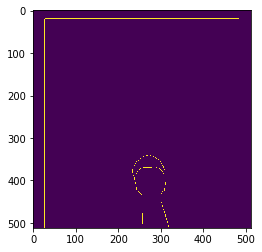

0


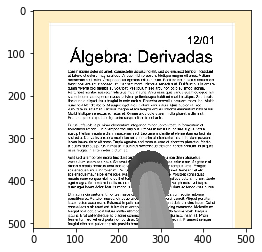

Algebra Derivadas
None


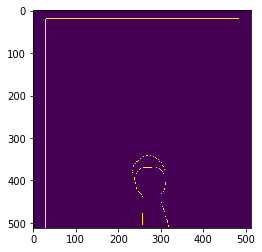

0


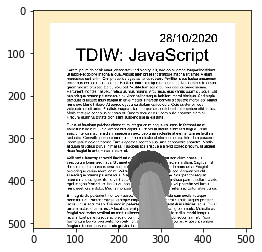

TDIW JavaScript
('Algebra Derivadas', 31)


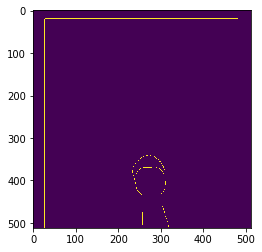

0


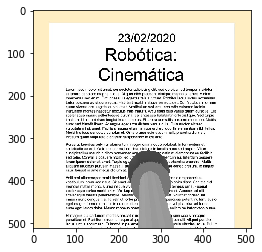

Robotica
('Algebra Derivadas', 34)


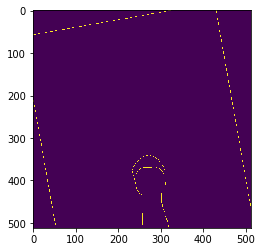

-10
-10


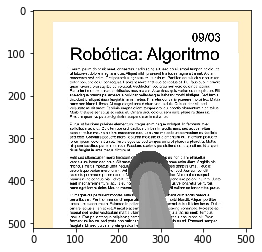

Robotica Algoritmo
('Robotica', 90)


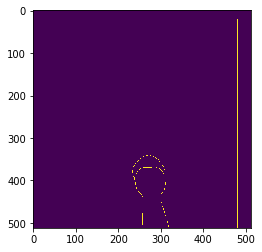

0


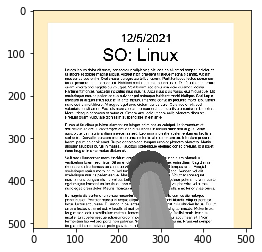

SO Linux
('TDIW JavaScript', 26)


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\cuent\anaconda3\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "<ipython-input-4-50201164ee5c>", line 12, in <lambda>
    boton1=Button(root,text="Clasificar",command=lambda:onclick(1))
  File "<ipython-input-4-50201164ee5c>", line 5, in onclick
    main()
  File "<ipython-input-10-bf89ff3ddf84>", line 52, in main
    img2=imagen()
  File "<ipython-input-3-7f7723e2a4e7>", line 15, in imagen
    img.resize([resolution[1],resolution[0],3])
IndexError: list index out of range


In [21]:
botones()

### TESTS:

In [15]:
def test_orientacion():
    
    """
    Comprueba que se realiza la orientación correcta de todos los archivadores.
        ESCENA: Test_orientar.ttt
    """
    retCode,joint1=sim.simxGetObjectHandle(clientID,'Joint1',sim.simx_opmode_blocking)
    retCode,joint2=sim.simxGetObjectHandle(clientID,'Joint2',sim.simx_opmode_blocking)
    retCode,joint3=sim.simxGetObjectHandle(clientID,'Joint3',sim.simx_opmode_blocking)
    retCode,camera=sim.simxGetObjectHandle(clientID,'Vision_sensor',sim.simx_opmode_blocking)
    retCode,suctionPad=sim.simxGetObjectHandle(clientID,'suctionPad',sim.simx_opmode_blocking)
    retCode,sensor=sim.simxGetObjectHandle(clientID,'Proximity_sensor',sim.simx_opmode_blocking)
    retCode,hoja1=sim.simxGetObjectHandle(clientID,'Hoja1',sim.simx_opmode_blocking)
    retCode,hoja2=sim.simxGetObjectHandle(clientID,'Hoja2',sim.simx_opmode_blocking)
    retCode,hoja3=sim.simxGetObjectHandle(clientID,'Hoja3',sim.simx_opmode_blocking)
    retCode,hoja4=sim.simxGetObjectHandle(clientID,'Hoja4',sim.simx_opmode_blocking)
    retCode,hoja5=sim.simxGetObjectHandle(clientID,'Hoja5',sim.simx_opmode_blocking)
    retCode,hoja6=sim.simxGetObjectHandle(clientID,'Hoja6',sim.simx_opmode_blocking)
    retCode,hoja7=sim.simxGetObjectHandle(clientID,'Hoja7',sim.simx_opmode_blocking)
    retCode,hoja8=sim.simxGetObjectHandle(clientID,'Hoja8',sim.simx_opmode_blocking)
    retCode,hoja9=sim.simxGetObjectHandle(clientID,'Hoja9',sim.simx_opmode_blocking)
    retCode,hoja10=sim.simxGetObjectHandle(clientID,'Hoja10',sim.simx_opmode_blocking)
    retCode,hoja11=sim.simxGetObjectHandle(clientID,'Hoja11',sim.simx_opmode_blocking)
    retCode,hoja12=sim.simxGetObjectHandle(clientID,'Hoja12',sim.simx_opmode_blocking)
    retCode,hoja13=sim.simxGetObjectHandle(clientID,'Hoja13',sim.simx_opmode_blocking)
    retCode,hoja14=sim.simxGetObjectHandle(clientID,'Hoja14',sim.simx_opmode_blocking)
    retCode,hoja15=sim.simxGetObjectHandle(clientID,'Hoja15',sim.simx_opmode_blocking)
    retCode,hoja16=sim.simxGetObjectHandle(clientID,'Hoja16',sim.simx_opmode_blocking)
    retCode,hoja17=sim.simxGetObjectHandle(clientID,'Hoja17',sim.simx_opmode_blocking)
    retCode,hoja18=sim.simxGetObjectHandle(clientID,'Hoja18',sim.simx_opmode_blocking)
    retCode,hoja19=sim.simxGetObjectHandle(clientID,'Hoja19',sim.simx_opmode_blocking)
    retCode,hoja20=sim.simxGetObjectHandle(clientID,'Hoja20',sim.simx_opmode_blocking)
   
    
    l=[hoja1,hoja2,hoja3,hoja4,hoja5,hoja6,hoja7,hoja8,hoja9,hoja10,hoja11,hoja12,hoja13,hoja14,hoja15,hoja16,hoja17,hoja18
      ,hoja19,hoja20]
    num_hojas=0
    altura_hoja=0.003
    error_total=0
    distancia_suelo=0.21
    for i in l:
        distancia=distancia_suelo-(num_hojas*altura_hoja) 
        RetCode,orientacion=sim.simxGetObjectOrientation(clientID,i, -1, sim.simx_opmode_blocking)
        Posicion_orientado()
        img=imagen()
        angulo=angle(img)
        orientar_hoja(angulo)   
        posicionar(-90,distancia) 
    for n,i in enumerate (l):
        RetCode,orientacion=sim.simxGetObjectOrientation(clientID,i, -1, sim.simx_opmode_blocking)
        error=math.degrees(orientacion[2])+90
        print("Error hoja ",n+1," ",error)
        error_total+=abs(error)
        num_hojas+=1
        
    print("Error total orientación páginas en grados :",error_total)

In [ ]:
test_orientacion()

In [32]:
def test_resultat_correcte():
    """
    Comprueba que se realiza la ordenación correcta de todos los archivadores.
        ESCENA: ordenar.ttt
    """
    actual_list=ordenarTodos()
    resultat_list= [['15/11/2020', '01/11/2020', '28/10/2020', '09/10/2020', '18/09/2020'],['12/01/2021', '23/01/2020', '17/11/2019'],['11/05/2020', '10/04/2020', '02/04/2020'],['02/12/2021', '08/08/2021'],['09/03/2021', '13/05/2020', '23/02/2020'],['12/05/2021', '09/02/2021']]
    if actual_list == resultat_list:
        return True
    else:
        return False

def test_arxivador_buit():
    """
    Comprueba que en caso de tener un archivador vacio se salta al siguiente.
        ESCENA: Test_ordenar_archivador_vacio.ttt
    """
    actual_list=ordenarTodos()
    resultat_list= [[],['12/01/2021', '23/01/2020', '17/11/2019'],[],['02/12/2021', '08/08/2021'],['09/03/2021', '13/05/2020', '23/02/2020'],['12/05/2021', '09/02/2021']]
    if actual_list == resultat_list:
        return True
    else:
        return False


In [ ]:
test_arxivador_buit()

In [ ]:
def test_titulos():
    """
    Comprueba que los titulos se extraen correctamente y que se eliminan los elementos que no aportan información.
        ESCENA: Test_ordenar_archivador_vacio.ttt
    """
    i=0
    correctos=0
    error=0
    lista_correcta=["Robotica Cinematica","VC tema de textura","VGI Gabbor", "Robotica Proyecto"]
    while i!=4:
        Posicion_orientado()
        generar_imagen()
        img=cv2.imread('Imagenes/foto.jpg')
        titulo=detectar_titulo()
        distancia=0.19
        posicionar(45,distancia)
        i=i+1
        mas_simil=similitud(titulo,lista_correcta)
        print(titulo,mas_simil)
        error=(100-mas_simil[1])+error
        
    porcentage_error=error/100
            
    return porcentage_error

In [ ]:
test_titulos()